In [2]:
from scipy.stats import chi2_contingency
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)


/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [65]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [4]:
os.makedirs('/kaggle/working/introverts', exist_ok=True)

In [4]:
train_df.to_csv('/kaggle/working/introverts/train_df.csv', index=False)

In [5]:
test_df.to_csv('/kaggle/working/introverts/test_df.csv', index=False)

In [6]:
a=pd.read_csv('/kaggle/working/introverts/train_df.csv')
a

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert


In [7]:
train_df.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [8]:
test_df.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [9]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     -------------- 

In [10]:
train_df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [11]:
test_df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [12]:
print("Train data", train_df.nunique())
print("\nTest data",test_df.nunique())

Train data id                           18524
Time_spent_Alone                12
Stage_fear                       2
Social_event_attendance         11
Going_outside                    8
Drained_after_socializing        2
Friends_circle_size             16
Post_frequency                  11
Personality                      2
dtype: int64

Test data id                           6175
Time_spent_Alone               12
Stage_fear                      2
Social_event_attendance        11
Going_outside                   8
Drained_after_socializing       2
Friends_circle_size            16
Post_frequency                 11
dtype: int64


In [13]:
print("Duplicates in train data:", train_df.duplicated().sum())
print("Duplicates in test data:", test_df.duplicated().sum())

Duplicates in train data: 0
Duplicates in test data: 0


In [14]:
print("Missing values in train data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in test data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in train data:
 id                            0.00%
Time_spent_Alone              6.42%
Stage_fear                   10.22%
Social_event_attendance       6.37%
Going_outside                 7.91%
Drained_after_socializing     6.20%
Friends_circle_size           5.69%
Post_frequency                6.82%
Personality                   0.00%
dtype: object

Missing values  in test data:
 id                           0.00%
Time_spent_Alone             6.88%
Stage_fear                   9.68%
Social_event_attendance      6.43%
Going_outside                7.55%
Drained_after_socializing    7.00%
Friends_circle_size          5.67%
Post_frequency               6.61%
dtype: object


<Axes: title={'center': 'Missing values in % for train and test'}>

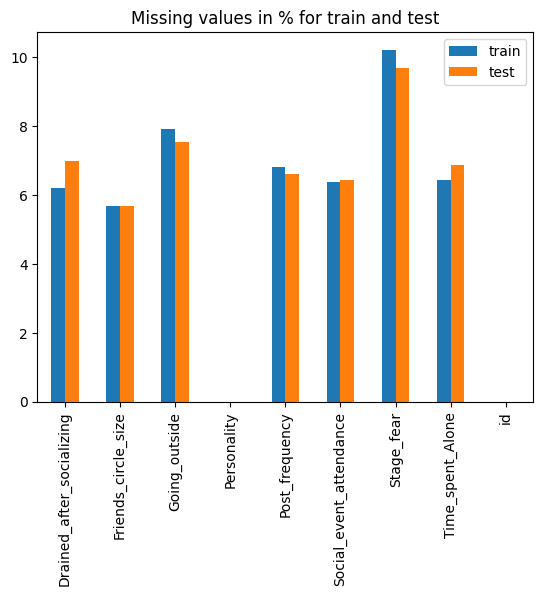

In [15]:
missing_data= pd.DataFrame({
    'train': train_df.isna().mean()*100,
    'test': test_df.isna().mean()*100
})
missing_data.plot(kind='bar', title='Missing values in % for train and test')

Personality
Extrovert    73.95
Introvert    26.05
Name: proportion, dtype: float64

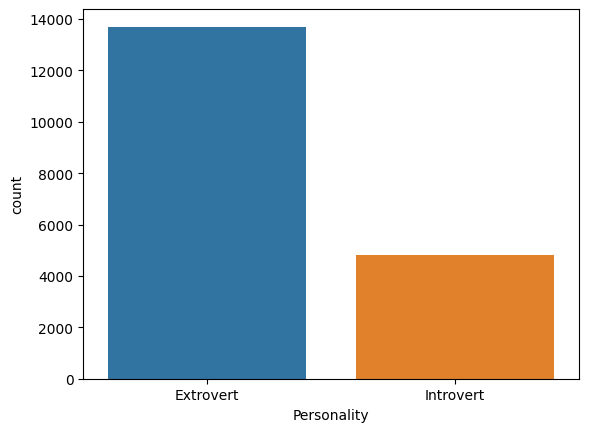

In [16]:
sns.countplot(data=train_df, x='Personality')
round(train_df['Personality'].value_counts(normalize=True)*100,2)

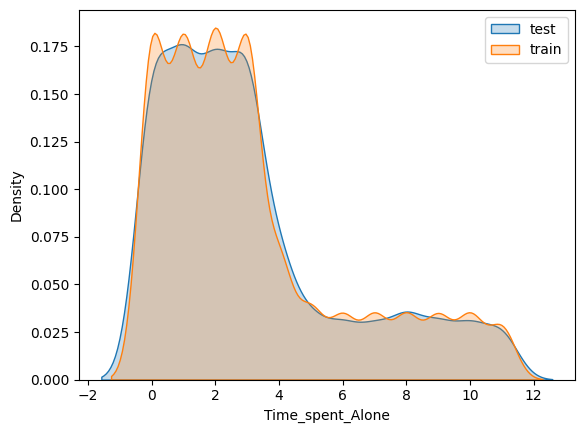

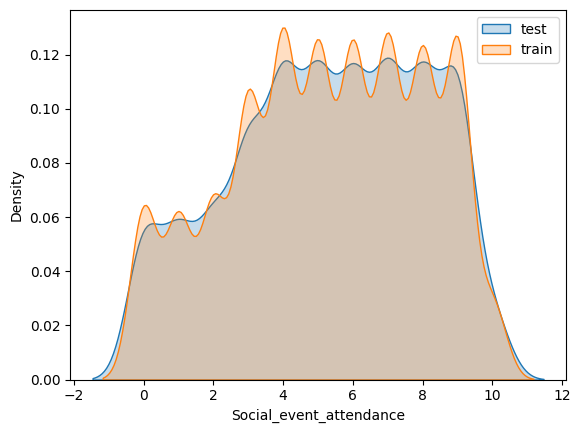

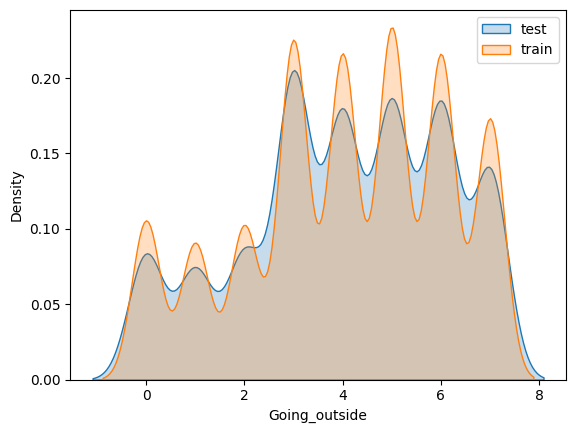

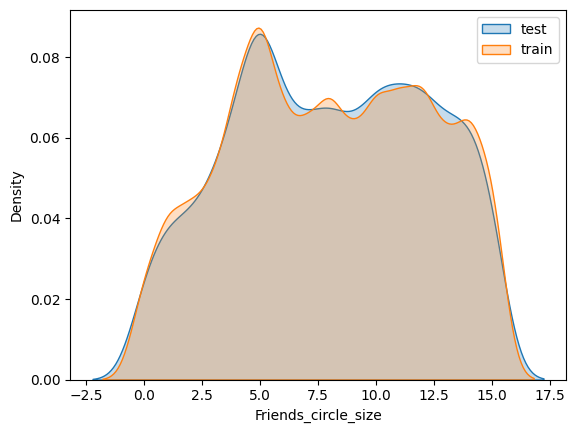

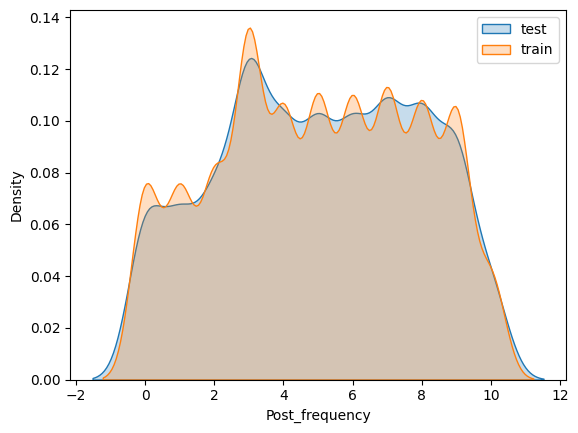

In [17]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(test_df[col], label='test', fill=True)
        sns.kdeplot(train_df[col], label='train', fill=True)
        plt.legend()
        plt.show()

<Axes: >

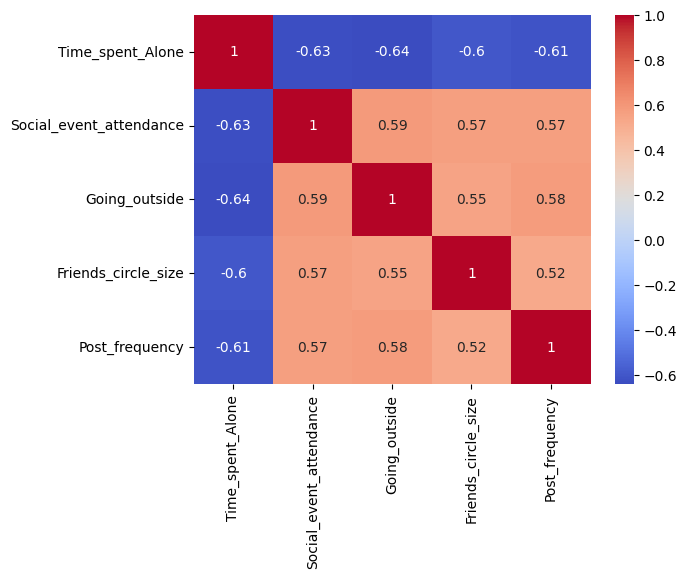

In [18]:
sns.heatmap(train_df[['Time_spent_Alone', 'Social_event_attendance','Going_outside', 'Friends_circle_size','Post_frequency']].corr(),
            annot = True, cmap='coolwarm')

<Axes: >

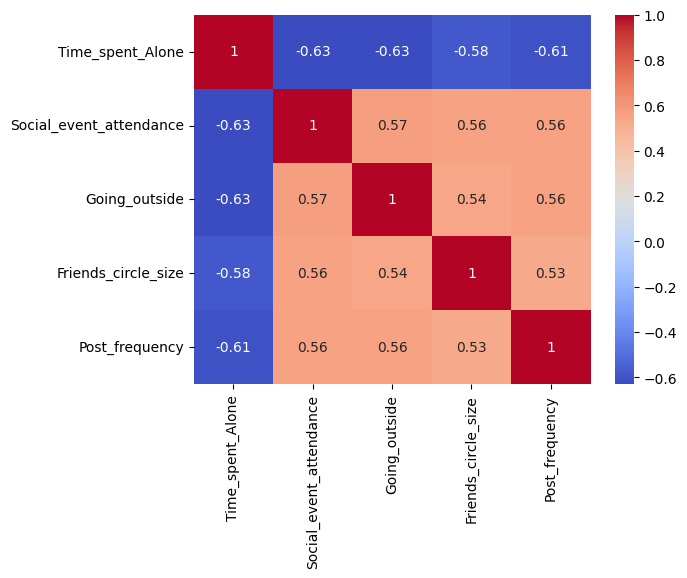

In [19]:
sns.heatmap(test_df[['Time_spent_Alone', 'Social_event_attendance','Going_outside', 'Friends_circle_size','Post_frequency']].corr(), 
            annot = True, cmap='coolwarm')

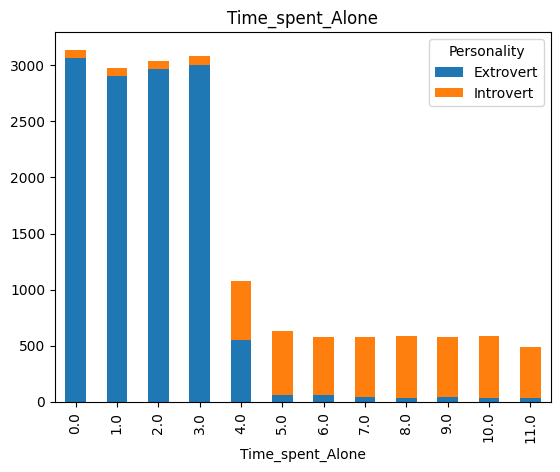

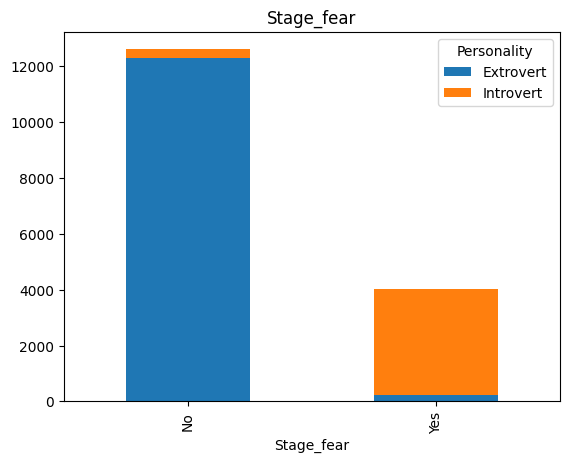

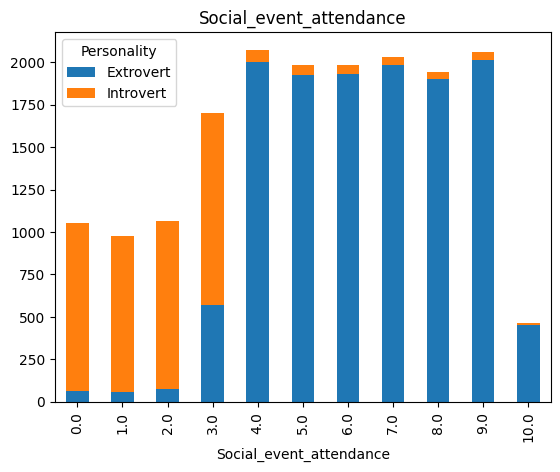

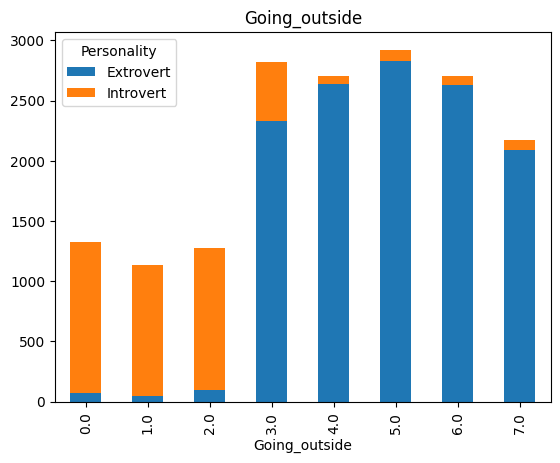

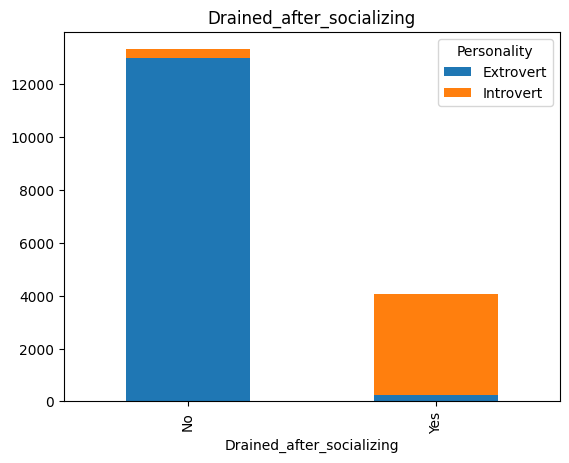

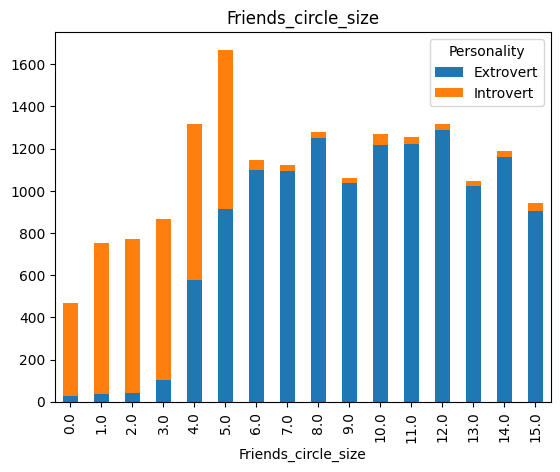

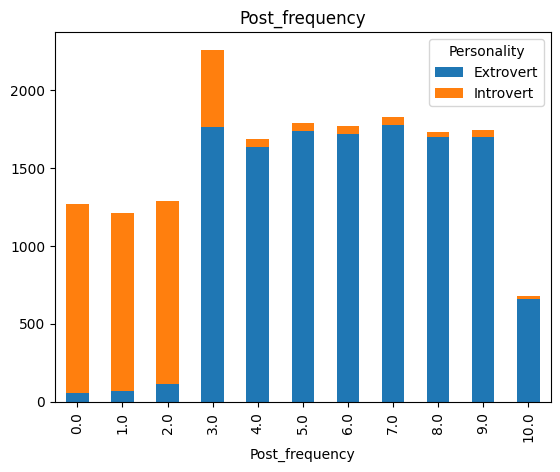

In [20]:
columns = [col for col in test_df.columns if col != 'id']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)

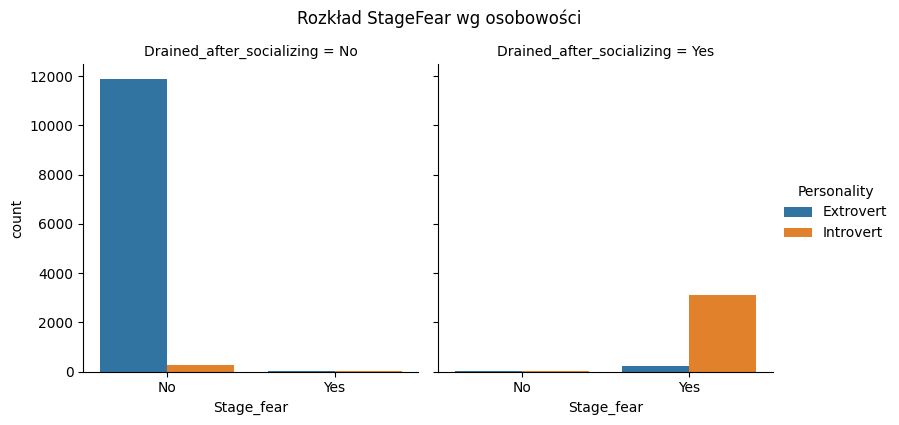

In [21]:
sns.catplot(
    data=train_df[train_df['Personality'].isin(['Introvert', 'Extrovert'])],  # tylko te grupy
    x="Stage_fear",
    hue="Personality",
    col="Drained_after_socializing",
    kind="count",
    height=4,
    aspect=1
)

plt.suptitle("Rozkład StageFear wg osobowości", y=1.05)
plt.show()

In [58]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

Drained_after_socializing     No   Yes
Personality Stage_fear                
Extrovert   No             11882     9
            Yes                5   207
Introvert   No               279     6
            Yes                8  3125

In [23]:
a=train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Extrovert') ]
a

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
1944,1944,8.0,No,0.0,1.0,Yes,4.0,2.0,Extrovert
2553,2553,9.0,No,2.0,3.0,Yes,3.0,1.0,Extrovert
3286,3286,NaN,No,3.0,2.0,Yes,5.0,1.0,Extrovert
6491,6491,6.0,No,5.0,2.0,Yes,5.0,2.0,Extrovert
10614,10614,4.0,No,3.0,0.0,Yes,5.0,NaN,Extrovert
12952,12952,1.0,No,4.0,5.0,Yes,15.0,5.0,Extrovert
15484,15484,10.0,No,3.0,0.0,Yes,NaN,3.0,Extrovert
17523,17523,2.0,No,6.0,4.0,Yes,13.0,3.0,Extrovert
17664,17664,0.0,No,3.0,7.0,Yes,4.0,7.0,Extrovert


In [24]:
b=train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Extrovert') ]
b

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
2192,2192,10.0,Yes,2.0,NaN,No,1.0,1.0,Extrovert
10996,10996,0.0,Yes,3.0,5.0,No,9.0,5.0,Extrovert
13468,13468,9.0,Yes,0.0,1.0,No,3.0,NaN,Extrovert
15264,15264,2.0,Yes,6.0,5.0,No,10.0,9.0,Extrovert
15574,15574,0.0,Yes,7.0,6.0,No,5.0,6.0,Extrovert


In [25]:
train_df[(train_df["Stage_fear"].isnull()) & (train_df["Drained_after_socializing"].isnull())]['Personality'].value_counts()

Personality
Introvert    24
Extrovert    15
Name: count, dtype: int64

In [26]:
a=train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Introvert') ]
a

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
7306,7306,10.0,No,3.0,2.0,Yes,NaN,0.0,Introvert
7804,7804,7.0,No,3.0,2.0,Yes,4.0,1.0,Introvert
8655,8655,10.0,No,3.0,0.0,Yes,0.0,0.0,Introvert
10304,10304,11.0,No,1.0,1.0,Yes,2.0,1.0,Introvert
13859,13859,7.0,No,1.0,2.0,Yes,5.0,3.0,Introvert
17184,17184,10.0,No,3.0,2.0,Yes,1.0,0.0,Introvert


In [27]:
b=train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Introvert') ]
b

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
1319,1319,8.0,Yes,2.0,1.0,No,4.0,NaN,Introvert
3891,3891,5.0,Yes,1.0,2.0,No,1.0,0.0,Introvert
5121,5121,11.0,Yes,2.0,0.0,No,7.0,1.0,Introvert
7340,7340,8.0,Yes,3.0,2.0,No,3.0,3.0,Introvert
12627,12627,5.0,Yes,3.0,2.0,No,4.0,1.0,Introvert
15146,15146,8.0,Yes,3.0,7.0,No,2.0,7.0,Introvert
15989,15989,6.0,Yes,2.0,2.0,No,4.0,1.0,Introvert
17002,17002,6.0,Yes,2.0,3.0,No,1.0,0.0,Introvert


In [28]:
train_introvert_df = train_df[train_df['Personality']=='Introvert']
train_extrovert_df = train_df[train_df['Personality']=='Extrovert']

In [29]:
introvert_no_no_df = train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Introvert')]
extrovert_yes_yes_df = train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Extrovert')]

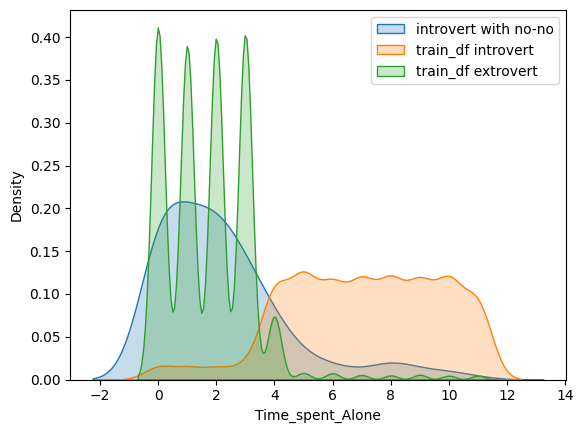

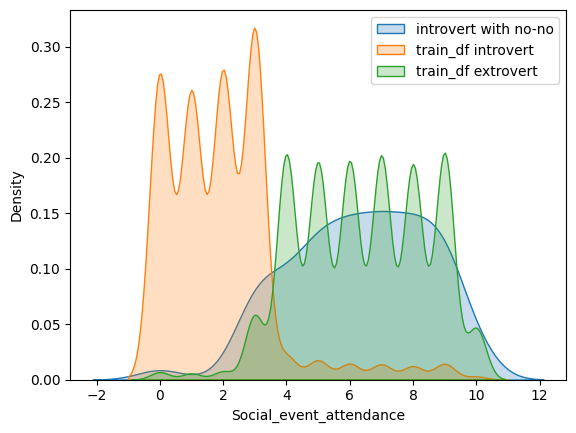

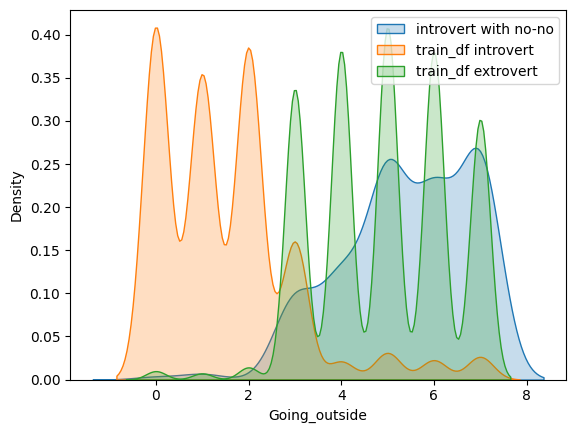

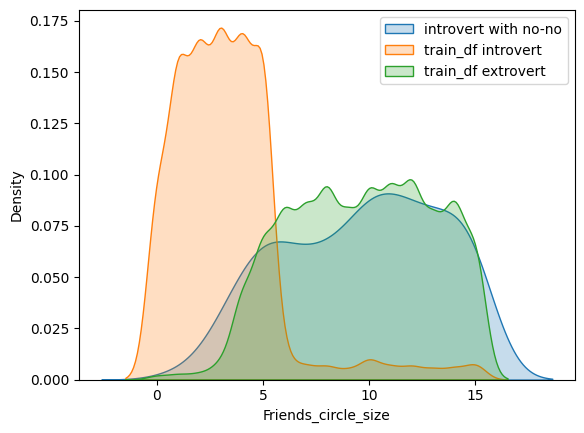

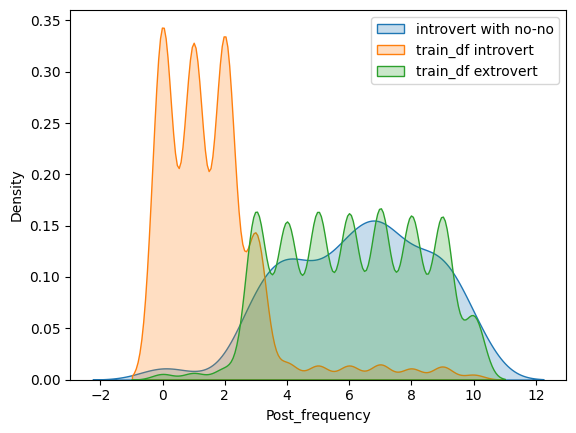

In [30]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

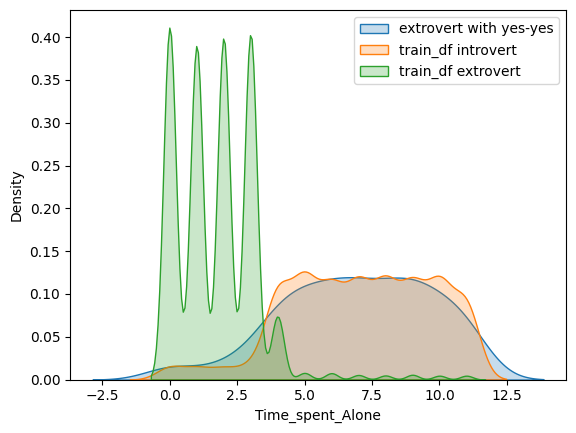

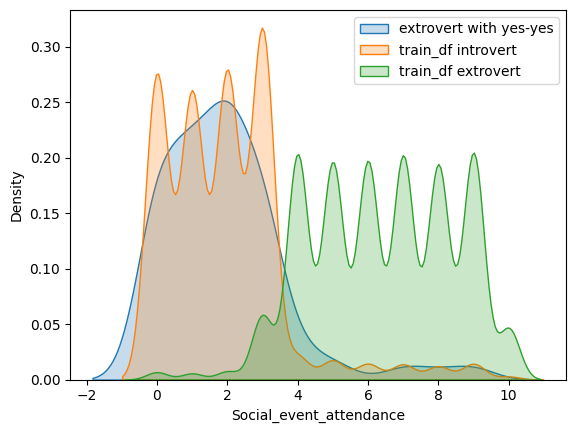

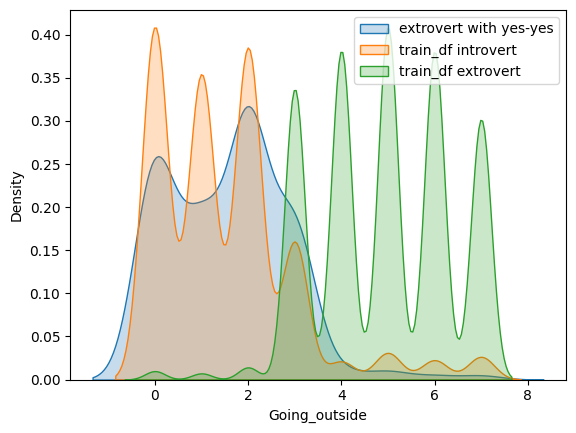

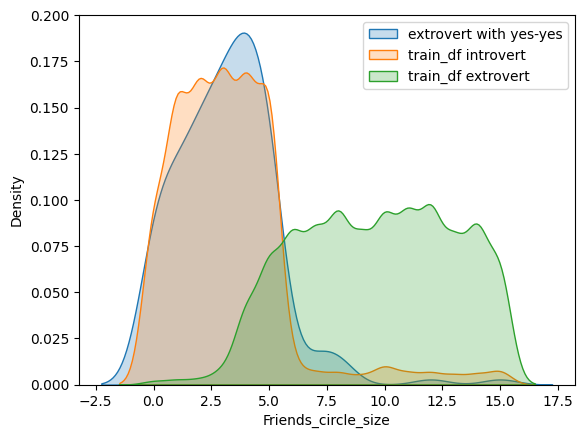

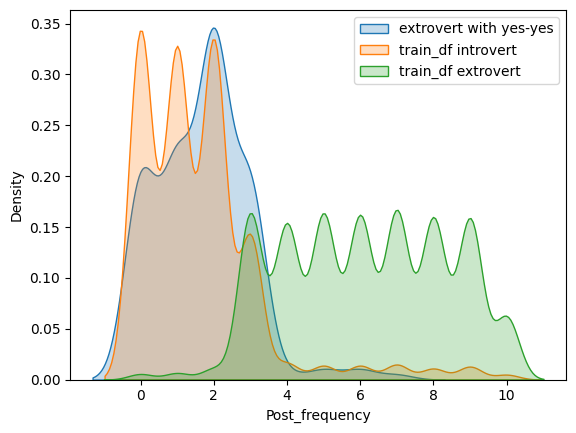

In [31]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

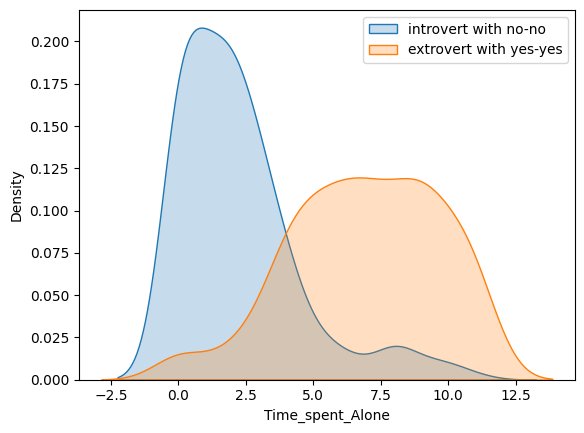

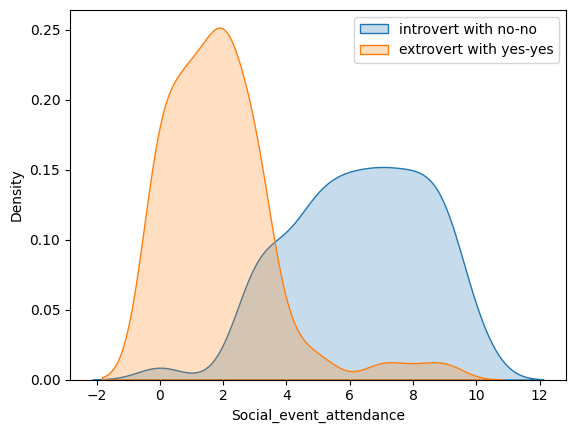

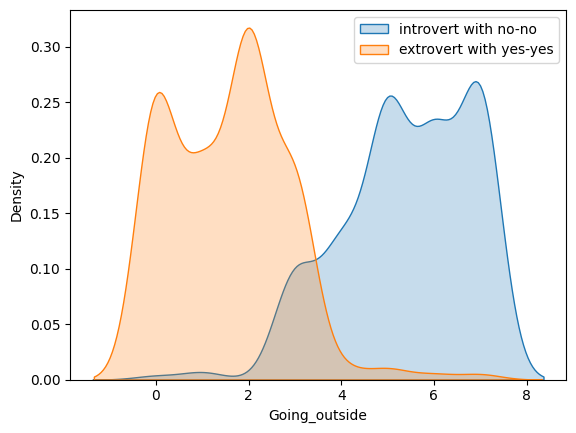

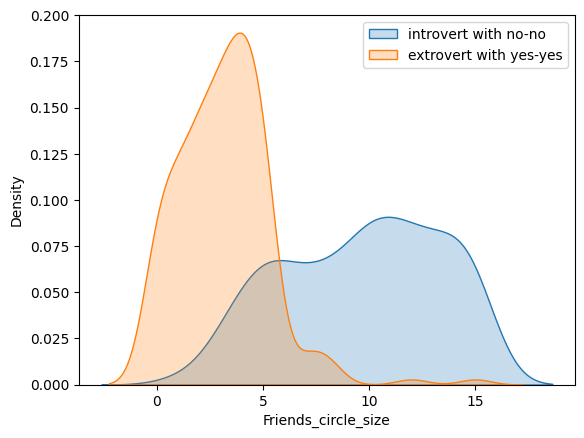

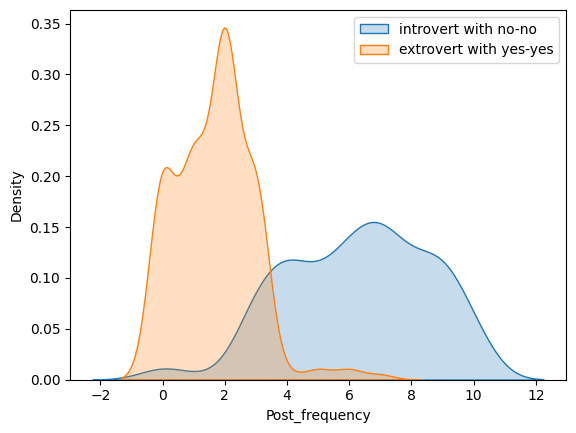

In [32]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)

        plt.legend()
        plt.show()

In [40]:
excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
# Przetwarzanie pozostałych kolumn
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

In [41]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality', 'Time_spent_Alone_MISS',
       'Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS',
       'Drained_after_socializing_MISS', 'Friends_circle_size_MISS',
       'Post_frequency_MISS'],
      dtype='object')

In [7]:

result = pd.crosstab(train_df['Time_spent_Alone_MISS'],train_df['Personality'], normalize='index')*100
chi2, p, _, _ = chi2_contingency(result)
print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}")

Chi2 = 0.069, p-value = 0.7935


In [ ]:
# Użyjemy tylko kolumn ['Stage_fear_MISS', 'Social_event_attendance_MISS','Drained_after_socializing_MISS','Post_frequency_MISS']

Chi2 = 0.069, p-value = 0.7935 Column: Time_spent_Alone_MISS 
Chi2 = 4.359, p-value = 0.0368 Column: Stage_fear_MISS 
Chi2 = 3.183, p-value = 0.0744 Column: Social_event_attendance_MISS 
Chi2 = 1.546, p-value = 0.2137 Column: Going_outside_MISS 
Chi2 = 25.141, p-value = 0.0000 Column: Drained_after_socializing_MISS 
Chi2 = 1.174, p-value = 0.2786 Column: Friends_circle_size_MISS 
Chi2 = 3.540, p-value = 0.0599 Column: Post_frequency_MISS 


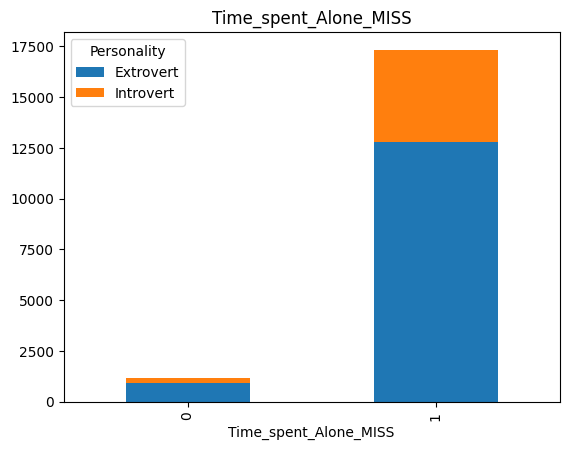

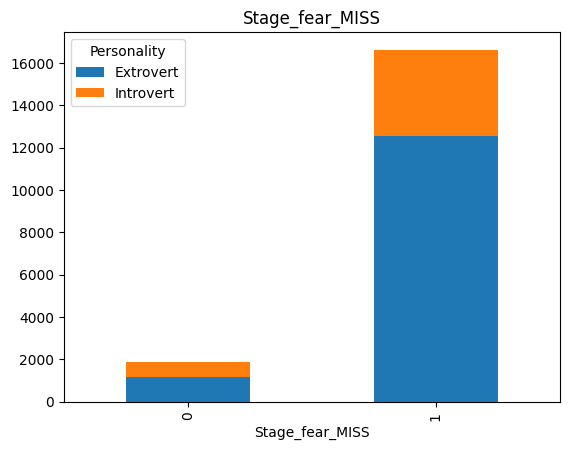

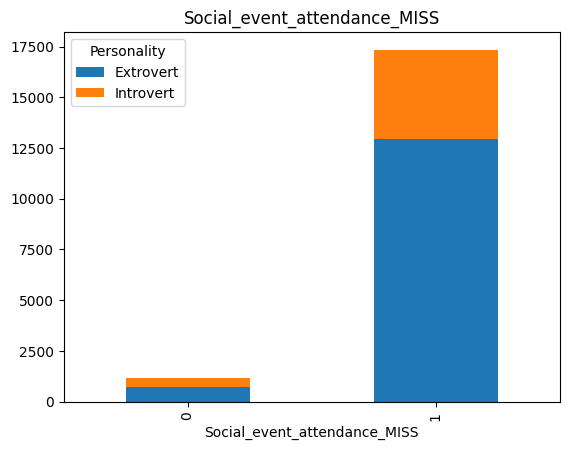

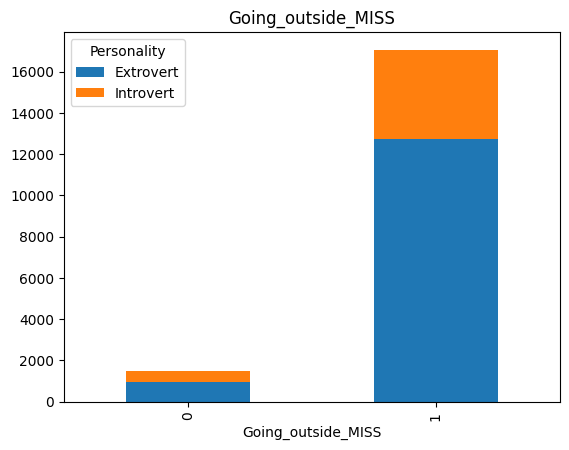

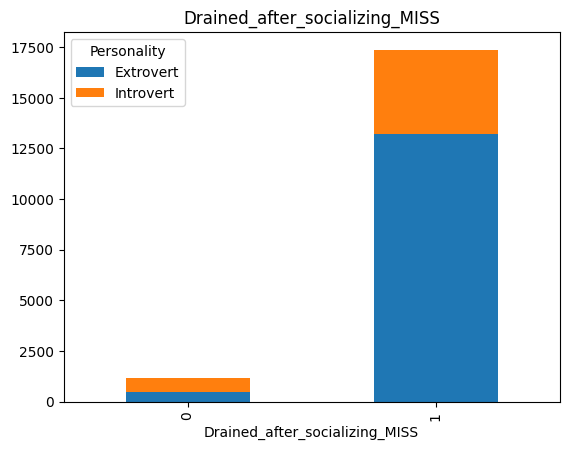

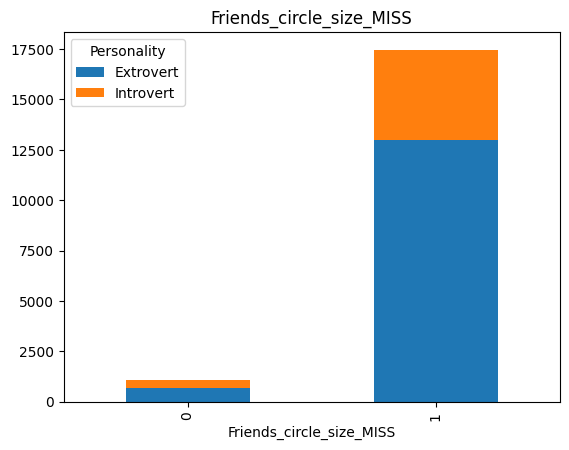

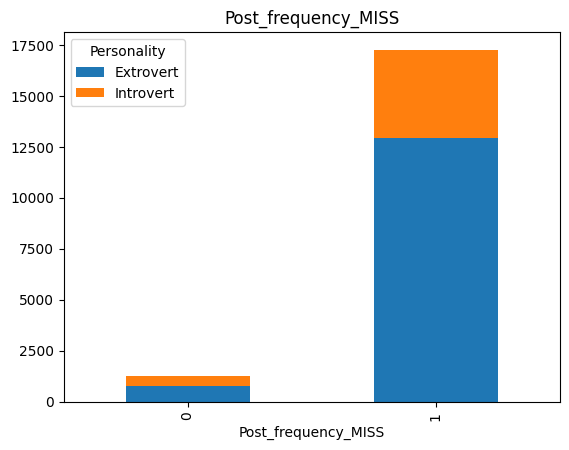

In [8]:
columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)
    result = pd.crosstab(train_df[col],train_df['Personality'], normalize='index')*100
    chi2, p, _, _ = chi2_contingency(result)
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f} Column: {col} ")

In [45]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality', 'Time_spent_Alone_MISS',
       'Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS',
       'Drained_after_socializing_MISS', 'Friends_circle_size_MISS',
       'Post_frequency_MISS'],
      dtype='object')

<Axes: title={'center': 'Summary'}, xlabel='Time_alona_outside'>

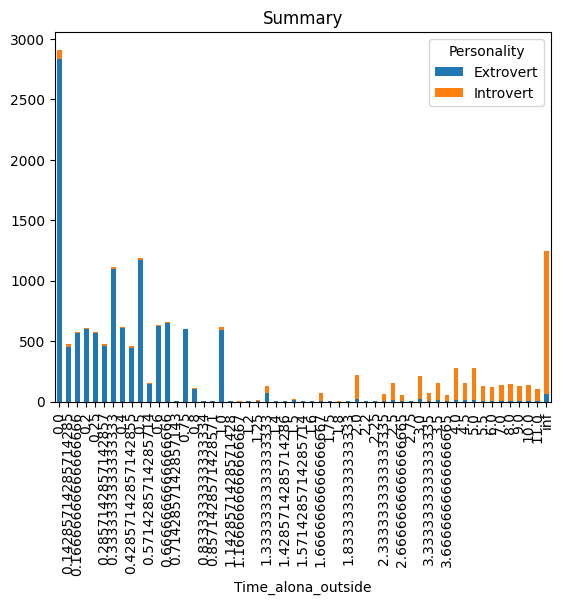

In [82]:
train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [79]:
train_df['Time_alona_outside'].value_counts()
result = pd.crosstab(train_df['Time_alona_outside'],train_df['Personality'], normalize='index')*100
result

Personality,Extrovert,Introvert
Time_alona_outside,,
0.000000,5.467801,94.532199
0.142857,50.000000,50.000000
0.200000,50.000000,50.000000
0.222222,100.000000,0.000000
0.250000,20.000000,80.000000
0.285714,100.000000,0.000000
0.300000,98.648649,1.351351
0.333333,74.111675,25.888325
0.375000,98.684211,1.315789


<Axes: title={'center': 'Summary'}, xlabel='Social_event_outside'>

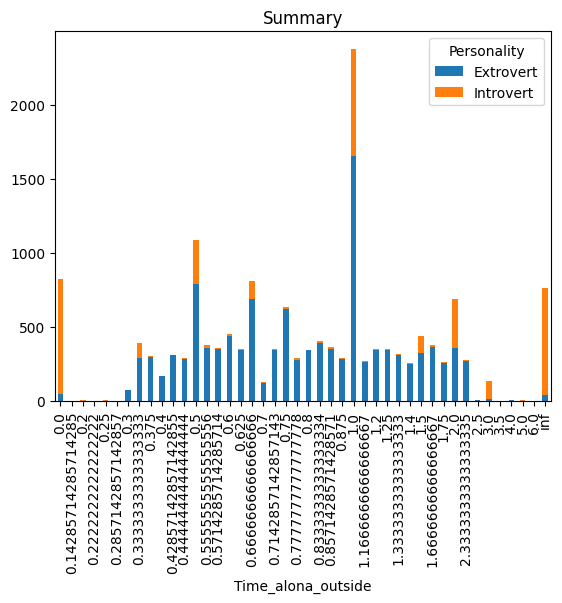

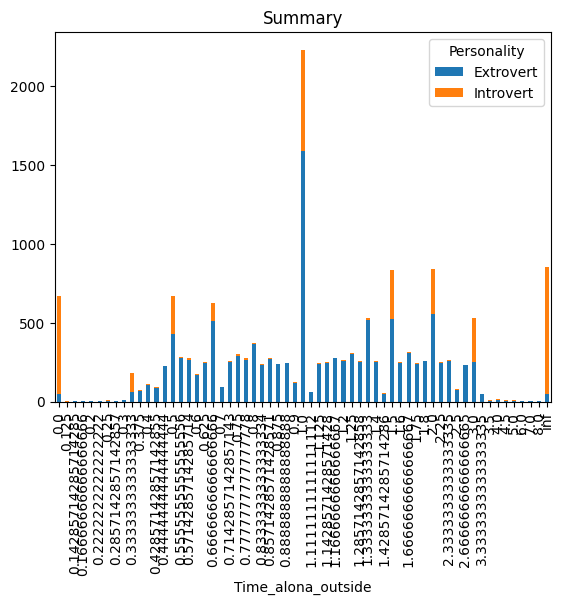

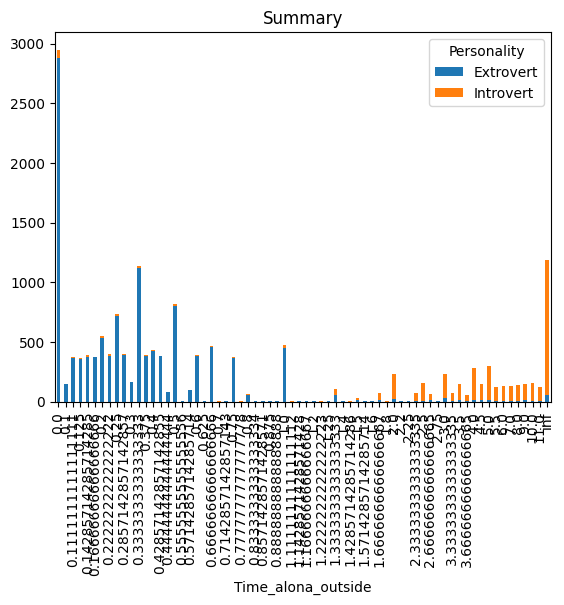

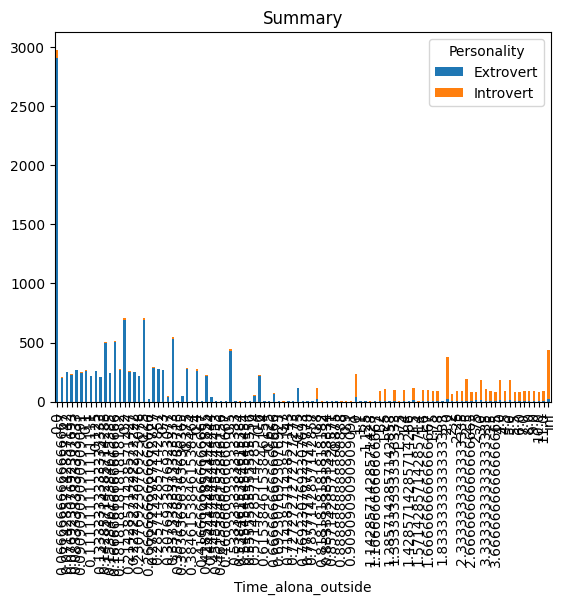

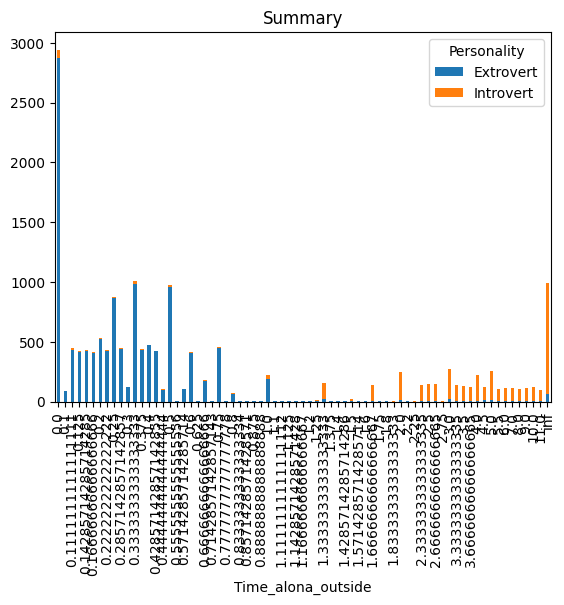

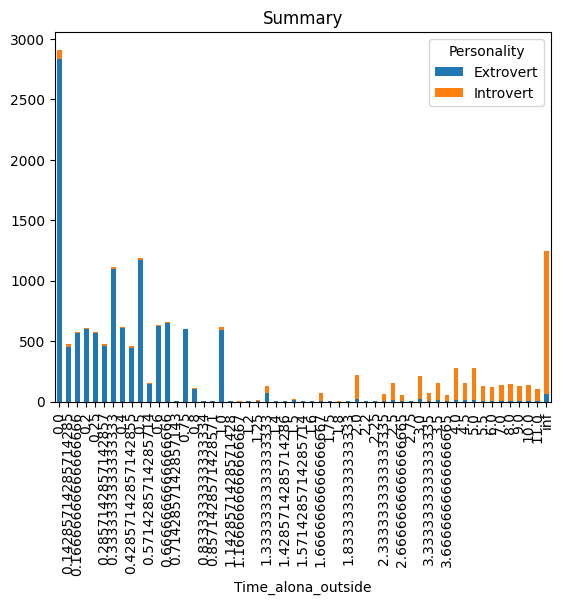

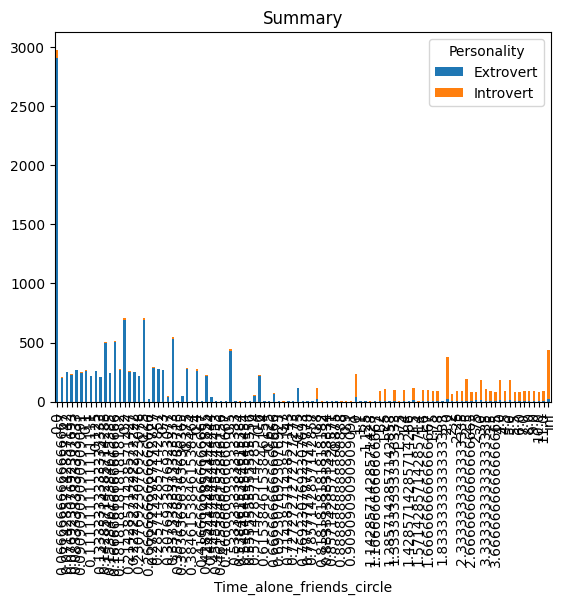

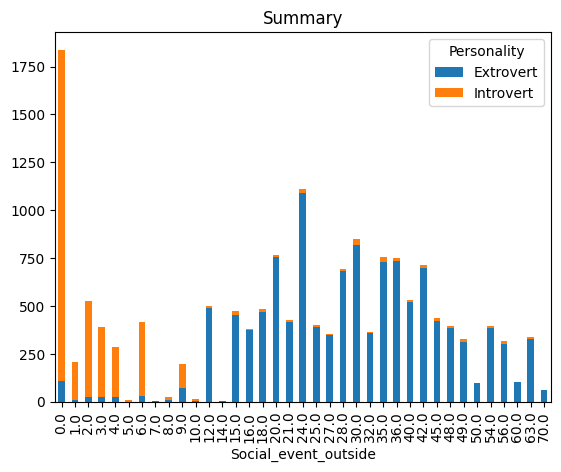

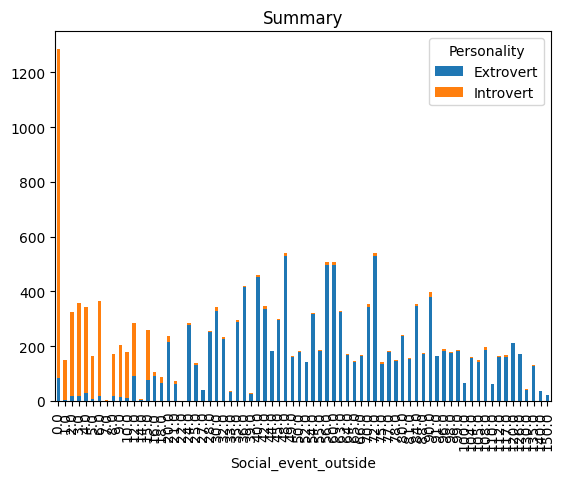

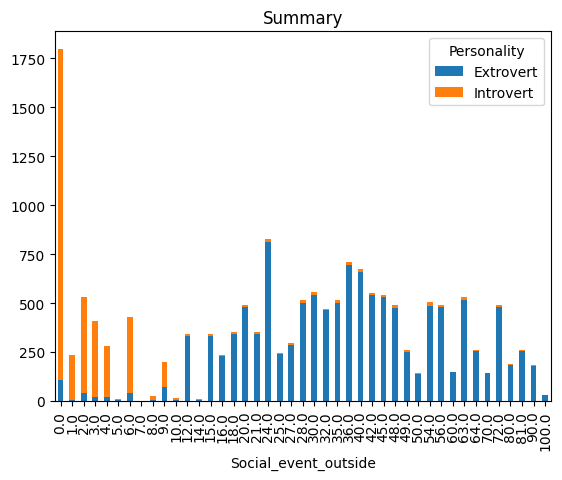

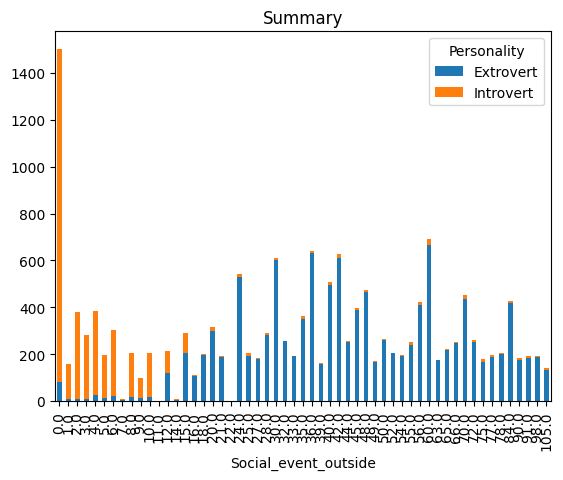

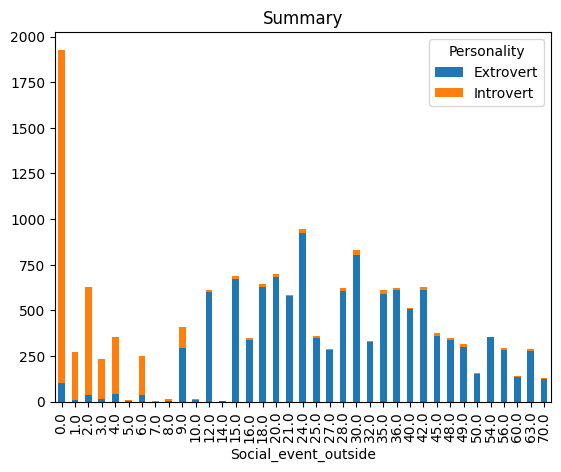

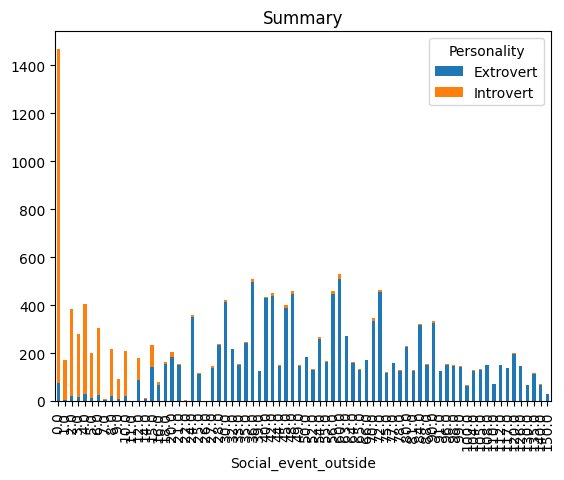

In [74]:
train_df['Time_alona_outside'] = train_df['Going_outside'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Social_event_attendance']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alone_friends_circle'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alone_friends_circle','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Social_event_attendance']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Friends_circle_size'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


<Axes: title={'center': 'Summary'}, xlabel='Summary'>

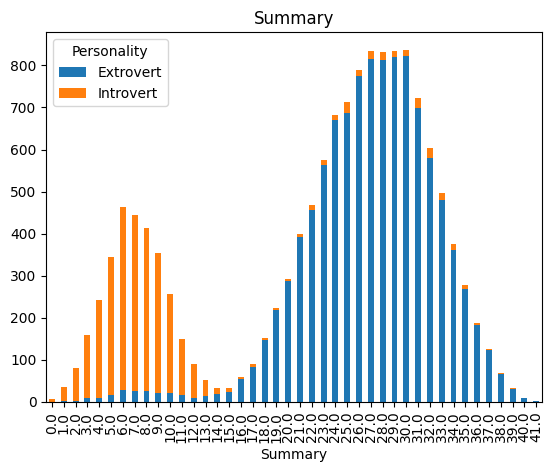

In [33]:
extrovert_col_df= pd.DataFrame({
    'Summary': train_df['Social_event_attendance']+train_df['Going_outside']+train_df['Friends_circle_size']+train_df['Post_frequency'],
    'Personality': train_df['Personality']
})
extrovert_col_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

# Imputacja brakujących danych 

In [9]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

# Do przetestowania czy lepiej bedzie uzupełnić Yes tam gdzie Yes i No gdzie No w kolumnach kategorycznych
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

test_df['Stage_fear'] = test_df['Stage_fear'].mask(test_df['Stage_fear'].isna() & test_df['Drained_after_socializing']
                                            .notna(), test_df['Drained_after_socializing'])
test_df['Drained_after_socializing'] = test_df['Drained_after_socializing'].mask(test_df['Drained_after_socializing']
                                            .isna() & test_df['Stage_fear'].notna(), test_df['Stage_fear'])

In [66]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

Drained_after_socializing     No   Yes
Personality Stage_fear                
Extrovert   No             11882     9
            Yes                5   207
Introvert   No               279     6
            Yes                8  3125

In [10]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality', 'Time_spent_Alone_MISS',
       'Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS',
       'Drained_after_socializing_MISS', 'Friends_circle_size_MISS',
       'Post_frequency_MISS'],
      dtype='object')

In [67]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']      # kolumny numeryczne

cat_cols = ['Stage_fear', 'Drained_after_socializing']      # kolumny numeryczne, 'D']      # kolumny kategoryczne (Yes/No)

In [68]:
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])
#TestDF[cat_cols] = cat_encoder.transform(TestDF[cat_cols])

In [53]:
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
#TestDF[num_cols] = num_imputer.transform(TestDF[num_cols])

In [69]:
cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
#TestDF[cat_cols] = cat_imputer.transform(TestDF[cat_cols])

In [ ]:
#Odzyskaj pierwotne etykiety "Yes"/"No"
#train_df[cat_cols] = cat_encoder.inverse_transform(train_df[cat_cols])
#TestDF[cat_cols] = cat_encoder.inverse_transform(TestDF[cat_cols])

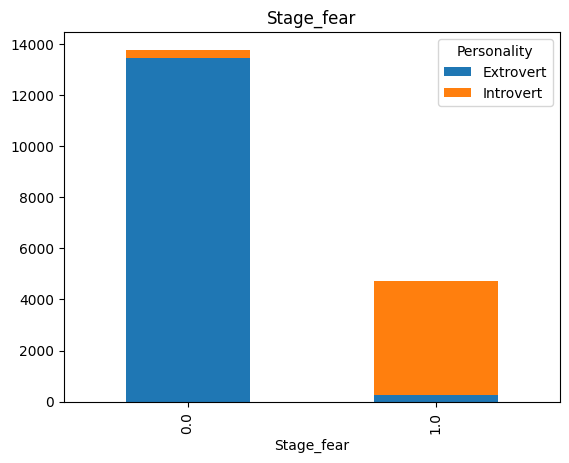

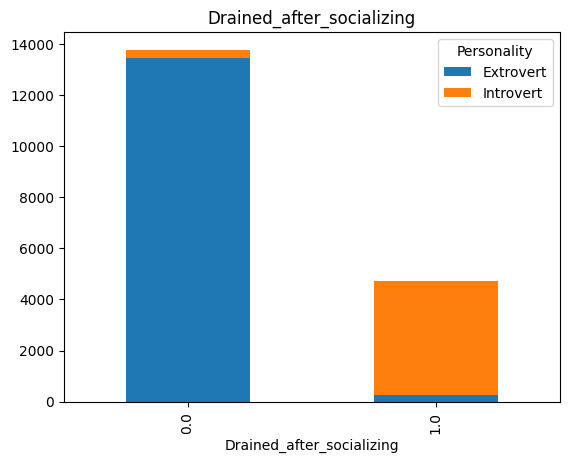

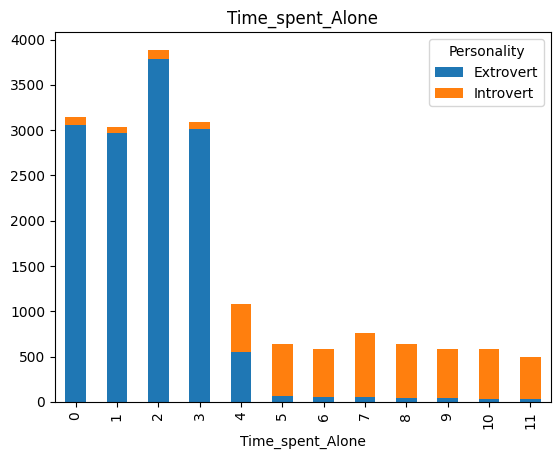

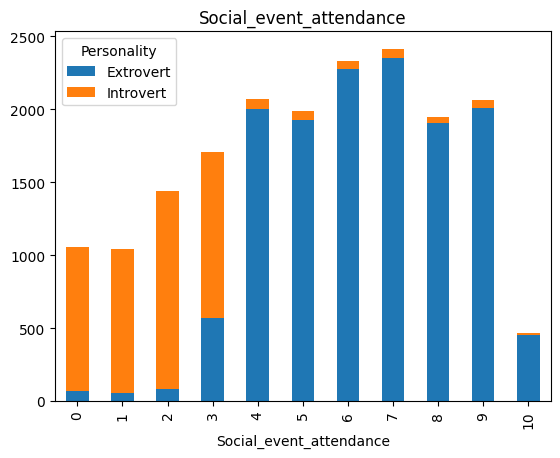

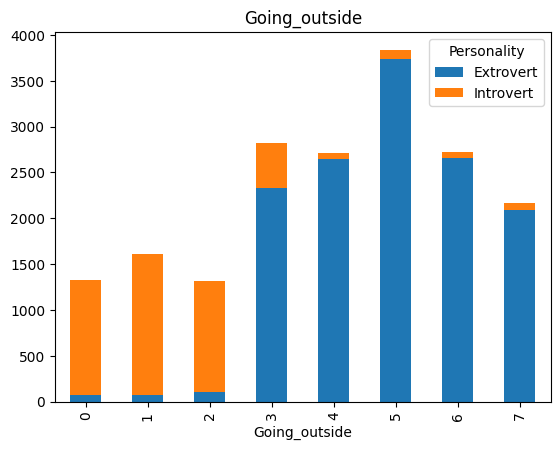

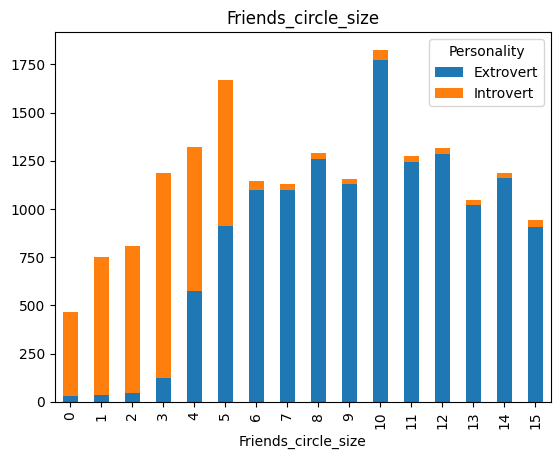

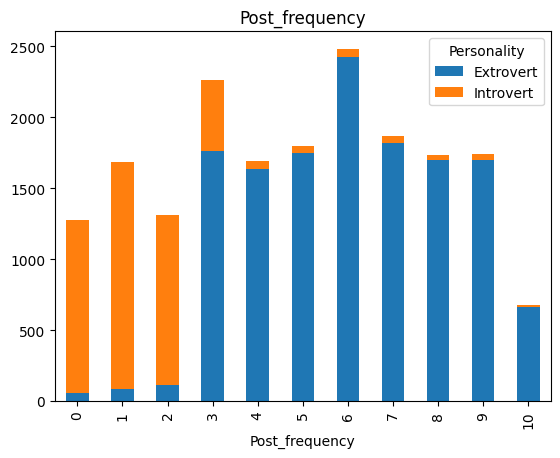

In [46]:
columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)
#test_df[columns]=test_df[columns].round().astype(int)

columns = ['Stage_fear', 'Drained_after_socializing','Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)

<Axes: title={'center': 'Summary'}, xlabel='Social_event_outside'>

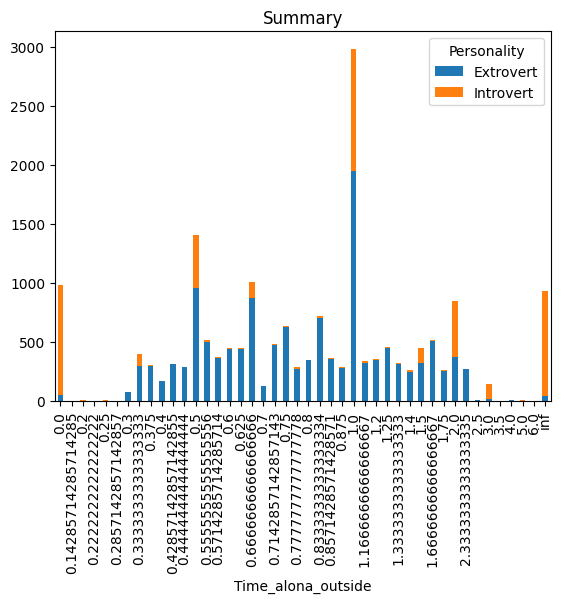

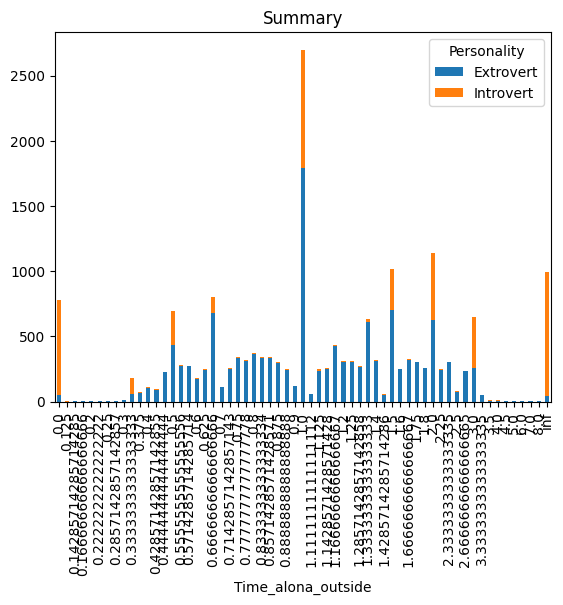

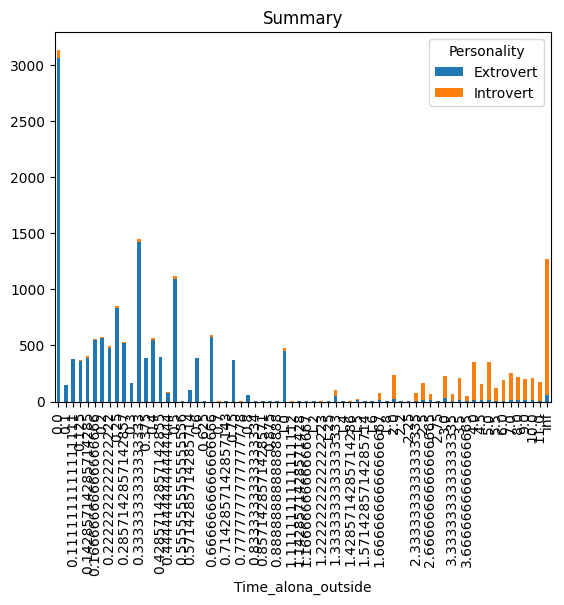

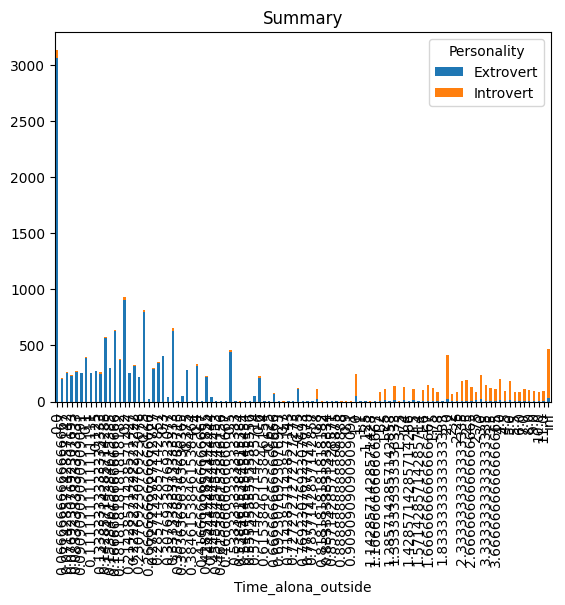

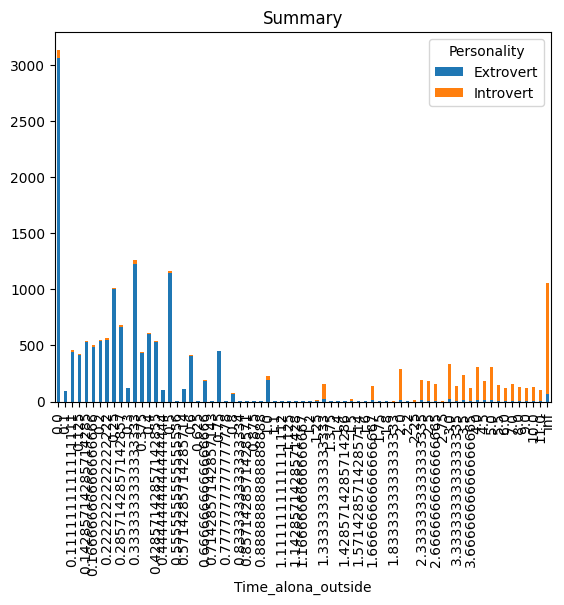

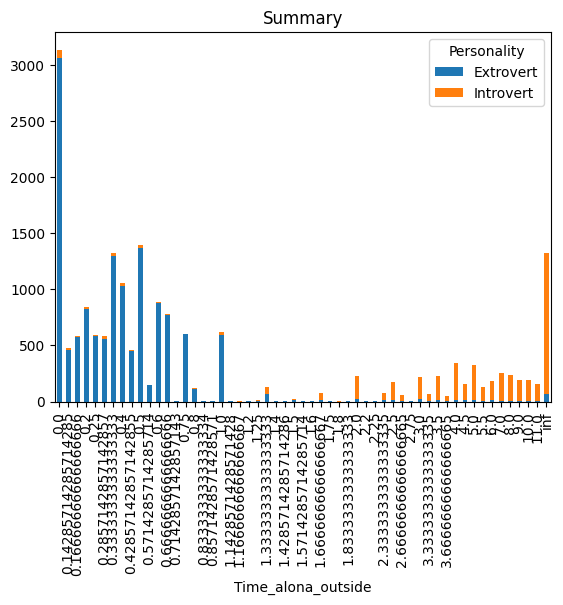

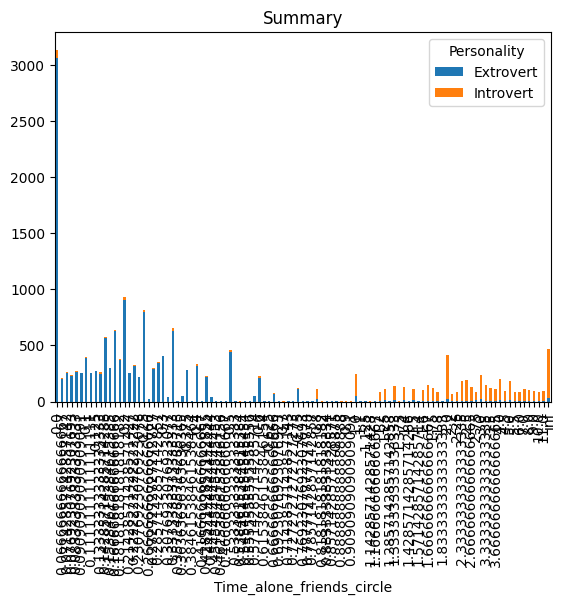

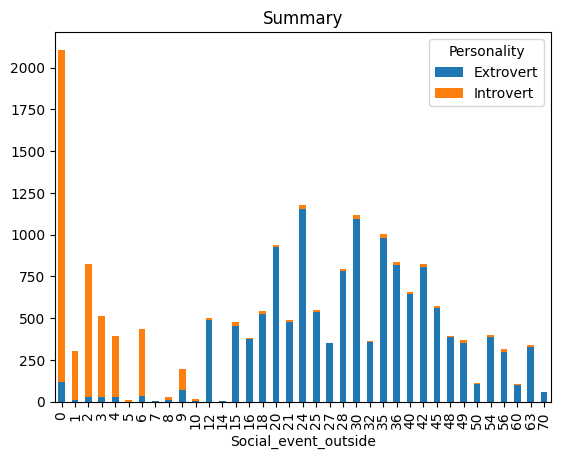

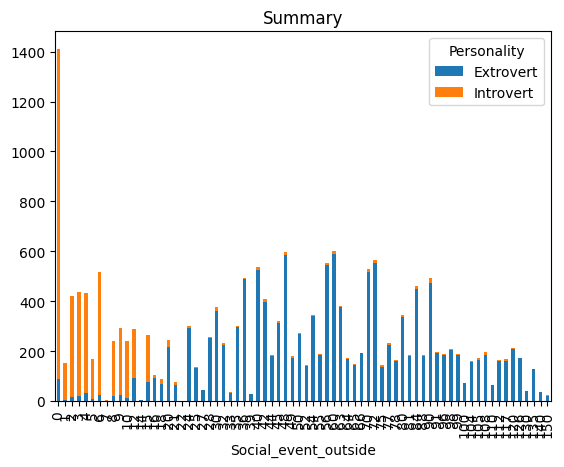

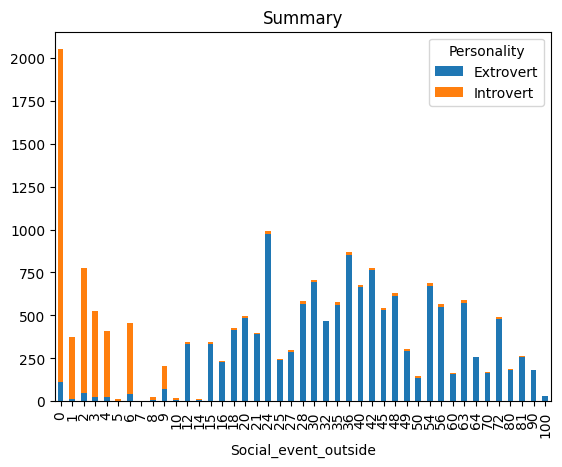

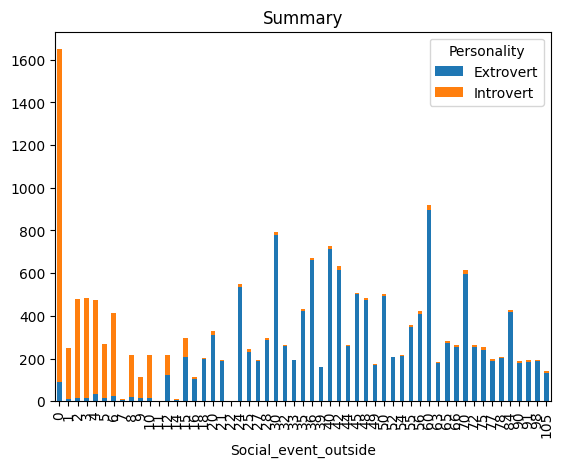

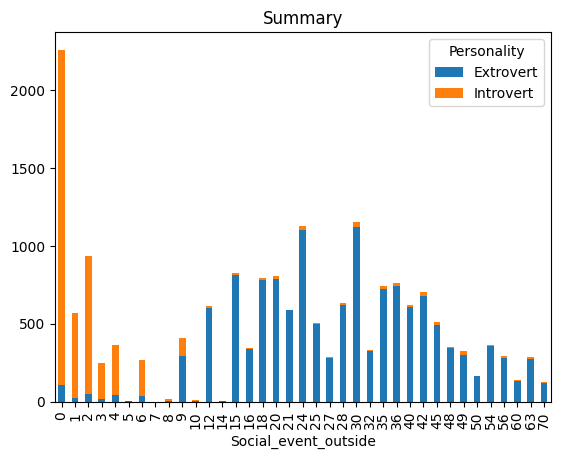

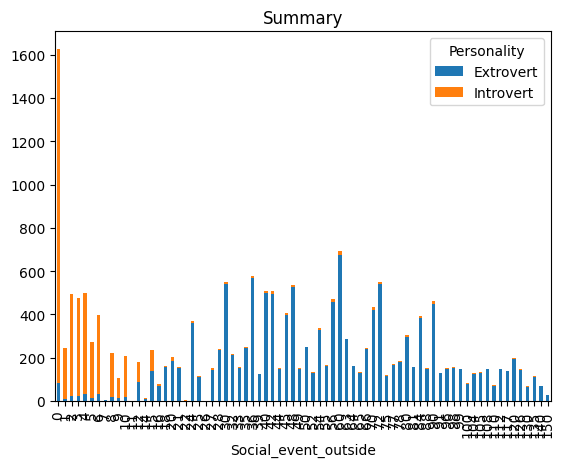

In [38]:
train_df['Time_alona_outside'] = train_df['Going_outside'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Social_event_attendance']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alone_friends_circle'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alone_friends_circle','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Social_event_attendance']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Friends_circle_size'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

In [70]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

Drained_after_socializing    0.0   1.0
Personality Stage_fear                
Extrovert   0.0            13434     9
            1.0                5   251
Introvert   0.0              338     6
            1.0                8  4473

In [34]:
print("Missing values in train data:\n",df_encoded.isna().mean().apply(lambda x: f"{x:.2%}"))

NameError: name 'df_encoded' is not defined

In [ ]:
df_encoded = train_df.copy()
#df_encoded['Drained_after_socializing'] = 
df_encoded['Stage_fear'] = df_encoded['Stage_fear'].mask(df_encoded['Stage_fear'].isna() & df_encoded['Drained_after_socializing']
                                            .notna(), df_encoded['Drained_after_socializing'])
df_encoded['Drained_after_socializing'] = df_encoded['Drained_after_socializing'].mask(df_encoded['Drained_after_socializing']
                                            .isna() & df_encoded['Stage_fear'].notna(), df_encoded['Stage_fear'])

In [ ]:
# Zakładamy: df to Twój DataFrame
cat_cols = ['Drained_after_socializing', 'Stage_fear']
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

# df_encoded = train_df.copy()

# Zamiana YES/NO na 1/0
for col in cat_cols:
    df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0})

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Imputer dla kolumn numerycznych
imp_num = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100), random_state=0)

# Fit na danych z kolumn numerycznych + dostępnych binarnych
num_data = df_encoded[num_cols + cat_cols]  # binarne też są pomocnicze przy imputowaniu
imputed_num = imp_num.fit_transform(num_data)

# Nadpisanie uzupełnionych danych numerycznych
df_encoded[num_cols] = imputed_num[:, :len(num_cols)]

for col in num_cols:
    df_encoded[col] = df_encoded[col].round().astype(int)


print("\nMissing values  in test data:\n",df_encoded.isna().mean().apply(lambda x: f"{x:.2%}"))

In [ ]:
imp_cat = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=0),
    max_iter=10
)

# Imputujemy kolumny binarne jako regresję
cat_data = df_encoded[cat_cols + num_cols]
imputed_cat = imp_cat.fit_transform(cat_data)

# Zaokrąglamy i przypisujemy jako int
for i, col in enumerate(cat_cols):
    df_encoded[col] = np.round(imputed_cat[:, i]).astype(int)

for col in cat_cols:
    df_encoded[col] = df_encoded[col].map({1: 'Yes', 0: 'No'})

In [ ]:
df_encoded['Personality'] = train_df['Personality']
columns = [col for col in test_df.columns if col != 'id']
for col in columns:
    df_encoded.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)

In [ ]:
print("\nMissing values  in test data:\n",df_encoded.isna().mean().apply(lambda x: f"{x:.2%}"))

In [ ]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

In [ ]:
pd.crosstab([df_encoded['Personality'],df_encoded["Stage_fear"]],df_encoded["Drained_after_socializing"]  )

In [ ]:
train_df.columns

for column in train_df.columns:
    mode_value = train_df[column].mode(dropna=True)
    if not mode_value.empty:
        train_df[column].fillna(mode_value[0], inplace=True)

df.isnull().sum().sort_values(ascending=False)

col_list.remove('id')
col_list.remove('Personality')

col_list

test_data = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
test_X = test_data[col_list].copy()
for column in test_X.columns:
    mode_value = test_X[column].mode(dropna=True)
    if not mode_value.empty:
        test_X[column].fillna(mode_value[0], inplace=True)
print(test_X.isnull().sum().sort_values(ascending=False))
test_X.head(5)

df_train = df.drop(['id','Personality'], axis=1).copy()
df_test = test_X.copy()
y = df['Personality'].copy()
categorical_cols = col_list

# Zakładam, że masz: 
# df_train — dane treningowe (bez SalePrice)
# df_test — dane testowe (do predykcji)
# y — target
# numerical_cols — lista kolumn numerycznych
# categorical_cols — lista kolumn kategorycznych

# 1. Wyciągamy tylko kolumny

X_train_cat = pd.get_dummies(df_train[categorical_cols], drop_first=True)
X_test_cat  = pd.get_dummies(df_test[categorical_cols], drop_first=True)

# 2. Dopasuj kolumny OneHotEncodera między train i test
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join="left", axis=1, fill_value=0)

# 3. Sklejamy numeryczne + zakodowane kategorie
X_train_final = X_train_cat
X_test_final  = X_test_cat



col_float= ['Time_spent_Alone','Social_event_attendance','Going_outside',
              'Friends_circle_size','Post_frequency']

X_train_final[col_float]=X_train_final[col_float].astype('Int64')
X_test_final[col_float]=X_test_final[col_float].astype('Int64')
X_test_final.head(1)

cat_features = X_test_final.columns.to_list()

# 4. Trenujemy model

model = CatBoostClassifier(
                            cat_features=cat_features,
                            iterations=800, #1000 najlepszy
                            learning_rate=0.05, #0.05 najlepszy
                            depth=6,
                            auto_class_weights = None,   # najlepszy'Balanced',
                            verbose=0
                          )

model.fit(X_train_final, y)

# 5. Predykcja na test.csv (do submission)
preds = model.predict(X_test_final)

df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

submission = pd.DataFrame({
    "id": df_test["id"],
    "Personality": preds
})
submission.to_csv("submission.csv", index=False)

print('Sukcesss!!!')